In [89]:
!pip install google-play-scraper
import csv
import requests
import re
import pandas as pd
from io import StringIO
from google_play_scraper import reviews_all, Sort

#Scarping data gojek

In [90]:
scrapreview = reviews_all(
    'com.gojek.app',
    lang = 'id',
    country = 'id',
    sort = Sort.MOST_RELEVANT,
    count = 10000
)

# Load data

In [91]:
# Mengonversi hasil scraping ke dalam DataFrame
df = pd.DataFrame(scrapreview)

# Menampilkan 5 baris pertama dataset
print("\nData setelah scraping (5 baris pertama):")
print(df.head())

# Mengecek apakah ada nilai NaN
print("\nJumlah nilai NaN dalam setiap kolom:")
print(df.isnull().sum())

# Menghapus baris yang memiliki nilai NaN
df.dropna(inplace=True)
print("\nJumlah nilai NaN setelah dibersihkan:")
print(df.isnull().sum())


Data setelah scraping (5 baris pertama):
                               reviewId         userName  \
0  595da86c-acc1-4a64-ae43-90ff85eaf53d  Pengguna Google   
1  9f871c14-7d44-4f0d-8cbe-9904d42cf3b6  Pengguna Google   
2  825e4595-c073-4388-8229-415e372b6c01  Pengguna Google   
3  ca02be83-772a-480a-a36c-7363e8176146  Pengguna Google   
4  606f946d-2bab-4c43-9b20-429a679a8fe0  Pengguna Google   

                                           userImage  \
0  https://play-lh.googleusercontent.com/EGemoI2N...   
1  https://play-lh.googleusercontent.com/EGemoI2N...   
2  https://play-lh.googleusercontent.com/EGemoI2N...   
3  https://play-lh.googleusercontent.com/EGemoI2N...   
4  https://play-lh.googleusercontent.com/EGemoI2N...   

                                             content  score  thumbsUpCount  \
0  terlalu terlalu terlalu... apk yg tidak bisa d...      1              1   
1  Gak usah pasang tarif tarif hemat, soalnya par...      1            207   
2  tinggal 2menit lg drive

#  Preprocessing Teks

In [92]:
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
!pip install Sastrawi
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory


def cleaningText(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text) # menghapus mention
    text = re.sub(r'#[A-Za-z0-9]+', '', text) # menghapus hashtag
    text = re.sub(r'RT[\s]', '', text) # menghapus RT
    text = re.sub(r"http\S+", '', text) # menghapus link
    text = re.sub(r'[0-9]+', '', text) # menghapus angka
    text = re.sub(r'[^\w\s]', '', text) # menghapus karakter selain huruf dan angka

    text = text.replace('\n', ' ') # mengganti baris baru dengan spasi
    text = text.translate(str.maketrans('', '', string.punctuation)) # menghapus semua tanda baca
    text = text.strip(' ') # menghapus karakter spasi dari kiri dan kanan teks
    return text

def casefoldingText(text): # Mengubah semua karakter dalam teks menjadi huruf kecil
    text = text.lower()
    return text

def tokenizingText(text): # Memecah atau membagi string, teks menjadi daftar token
    text = word_tokenize(text)
    return text

def filteringText(text): # Menghapus stopwords dalam teks
    listStopwords = set(stopwords.words('indonesian'))
    listStopwords1 = set(stopwords.words('english'))
    listStopwords.update(listStopwords1)
    listStopwords.update(['iya','yaa','gak','nya','na','sih','ku',"di","ga","ya","gaa","loh","kah","woi","woii","woy"])
    filtered = []
    for txt in text:
        if txt not in listStopwords:
            filtered.append(txt)
    text = filtered
    return text

def stemmingText(text): # Mengurangi kata ke bentuk dasarnya yang menghilangkan imbuhan awalan dan akhiran atau ke akar kata
    # Membuat objek stemmer
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()

    # Memecah teks menjadi daftar kata
    words = text.split()

    # Menerapkan stemming pada setiap kata dalam daftar
    stemmed_words = [stemmer.stem(word) for word in words]

    # Menggabungkan kata-kata yang telah distem
    stemmed_text = ' '.join(stemmed_words)

    return stemmed_text

def toSentence(list_words): # Mengubah daftar kata menjadi kalimat
    sentence = ' '.join(word for word in list_words)
    return sentence
slangwords = {"@": "di", "abis": "habis", "wtb": "beli", "masi": "masih", "wts": "jual", "wtt": "tukar", "bgt": "banget", "maks": "maksimal"}
def fix_slangwords(text):
    words = text.split()
    fixed_words = []

    for word in words:
        if word.lower() in slangwords:
            fixed_words.append(slangwords[word.lower()])
        else:
            fixed_words.append(word)

    fixed_text = ' '.join(fixed_words)
    return fixed_text
    fixed_words = []

    for word in words:
        if word.lower() in slangwords:
            fixed_words.append(slangwords[word.lower()])
        else:
            fixed_words.append(word)

    fixed_text = ' '.join(fixed_words)
    return fixed_text

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

clean_df = df.copy()

# Membersihkan teks dan menyimpannya di kolom 'text_clean'
clean_df['text_clean'] = clean_df['content'].apply(cleaningText)

# Mengubah huruf dalam teks menjadi huruf kecil dan menyimpannya di 'text_casefoldingText'
clean_df['text_casefoldingText'] = clean_df['text_clean'].apply(casefoldingText)

# Mengganti kata-kata slang dengan kata-kata standar dan menyimpannya di 'text_slangwords'
clean_df['text_slangwords'] = clean_df['text_casefoldingText'].apply(fix_slangwords)

# Memecah teks menjadi token (kata-kata) dan menyimpannya di 'text_tokenizingText'
clean_df['text_tokenizingText'] = clean_df['text_slangwords'].apply(tokenizingText)

# Menghapus kata-kata stop (kata-kata umum) dan menyimpannya di 'text_stopword'
clean_df['text_stopword'] = clean_df['text_tokenizingText'].apply(filteringText)

# Menggabungkan token-token menjadi kalimat dan menyimpannya di 'text_akhir'
clean_df['text_akhir'] = clean_df['text_stopword'].apply(toSentence)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


#Pelabelan

In [93]:
import requests
from io import StringIO

# Membaca data kamus kata-kata positif dari GitHub
lexicon_positive = dict()

response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_positive.csv')
# Mengirim permintaan HTTP untuk mendapatkan file CSV dari GitHub

if response.status_code == 200:
    # Jika permintaan berhasil
    reader = csv.reader(StringIO(response.text), delimiter=',')
    # Membaca teks respons sebagai file CSV menggunakan pembaca CSV dengan pemisah koma

    for row in reader:
        # Mengulangi setiap baris dalam file CSV
        lexicon_positive[row[0]] = int(row[1])
        # Menambahkan kata-kata positif dan skornya ke dalam kamus lexicon_positive
else:
    print("Failed to fetch positive lexicon data")

# Membaca data kamus kata-kata negatif dari GitHub
lexicon_negative = dict()

response = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_negative.csv')
# Mengirim permintaan HTTP untuk mendapatkan file CSV dari GitHub

if response.status_code == 200:
    # Jika permintaan berhasil
    reader = csv.reader(StringIO(response.text), delimiter=',')
    # Membaca teks respons sebagai file CSV menggunakan pembaca CSV dengan pemisah koma

    for row in reader:
        # Mengulangi setiap baris dalam file CSV
        lexicon_negative[row[0]] = int(row[1])
        # Menambahkan kata-kata negatif dan skornya dalam kamus lexicon_negative
else:
    print("Failed to fetch negative lexicon data")
# Fungsi untuk menentukan polaritas sentimen dari tweet

def sentiment_analysis_lexicon_indonesia(text):
    #for word in text:

    score = 0
    # Inisialisasi skor sentimen ke 0

    for word in text:
        # Mengulangi setiap kata dalam teks

        if (word in lexicon_positive):
            score = score + lexicon_positive[word]
            # Jika kata ada dalam kamus positif, tambahkan skornya ke skor sentimen

    for word in text:
        # Mengulangi setiap kata dalam teks (sekali lagi)

        if (word in lexicon_negative):
            score = score + lexicon_negative[word]
            # Jika kata ada dalam kamus negatif, kurangkan skornya dari skor sentimen

    polarity=''
    # Inisialisasi variabel polaritas

    if (score >= 0):
        polarity = 'positive'
        # Jika skor sentimen lebih besar atau sama dengan 0, maka polaritas adalah positif
    elif (score < 0):
        polarity = 'negative'
        # Jika skor sentimen kurang dari 0, maka polaritas adalah negatif

    return score, polarity
    # Mengembalikan skor sentimen dan polaritas teks
results = clean_df['text_stopword'].apply(sentiment_analysis_lexicon_indonesia)
results = list(zip(*results))
clean_df['polarity_score'] = results[0]
clean_df['sentiment'] = results[1]
print(clean_df['sentiment'].value_counts())

# --- 6. Simpan ke CSV ---
clean_df.to_csv("data_scraping_gojek.csv", index=False)
print("Data berhasil disimpan sebagai data_lexicon_labeled.csv")

sentiment
negative    19728
positive    12455
Name: count, dtype: int64
Data berhasil disimpan sebagai data_lexicon_labeled.csv


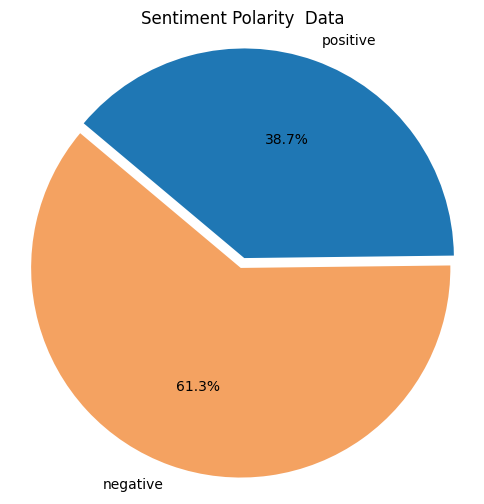

In [96]:
import matplotlib.pyplot as plt

# Hitung distribusi polaritas
polarity_counts = clean_df['sentiment'].value_counts()
labels = polarity_counts.index
sizes = polarity_counts.values
colors = ['#f4a261', '#1f77b4', '#2ca02c']
explode = [0.05 if label == 'positive' else 0 for label in labels]

# Plot pie chart
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors[:len(labels)],
        startangle=140, explode=explode)
plt.title('Sentiment Polarity  Data')
plt.axis('equal')
plt.show()


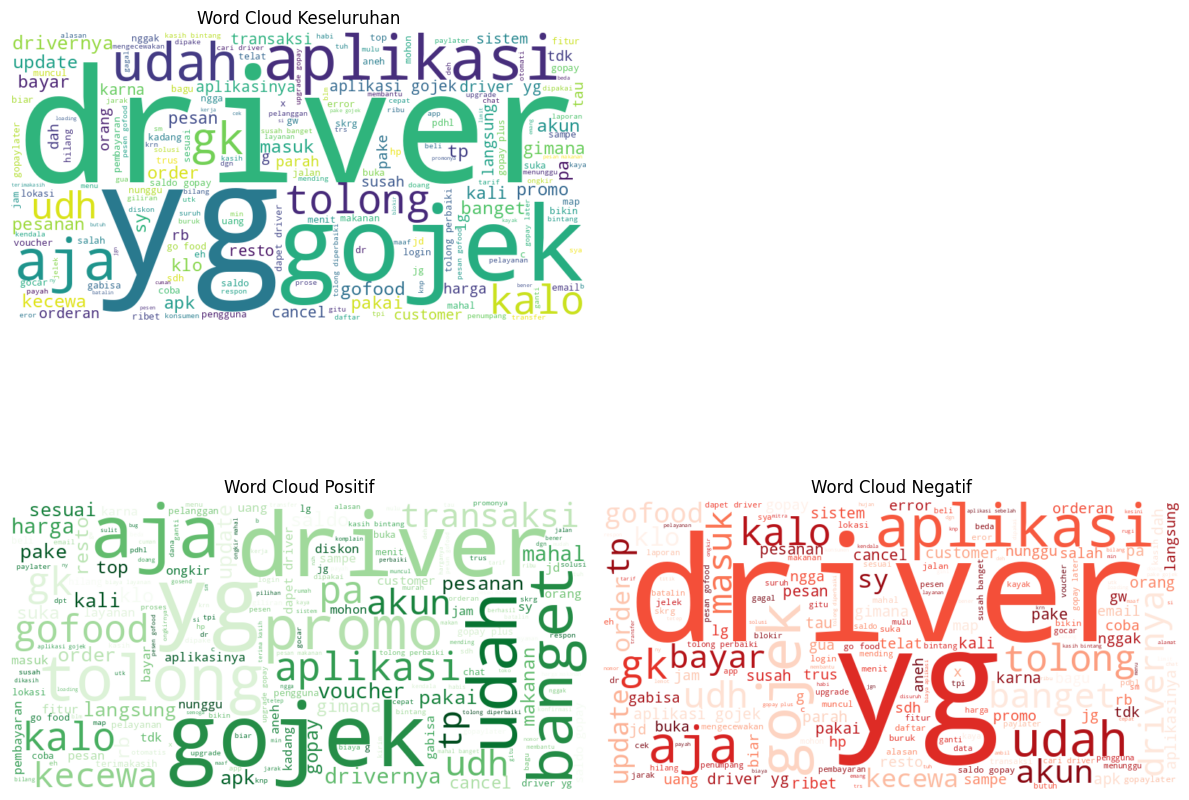

In [95]:
from wordcloud import WordCloud


# Menggabungkan semua kata berdasarkan kategori
all_text = ' '.join([' '.join(text) for text in clean_df['text_stopword']])
positive_text = ' '.join([' '.join(text) for text in clean_df[clean_df['sentiment'] == 'positive']['text_stopword']])
negative_text = ' '.join([' '.join(text) for text in clean_df[clean_df['sentiment'] == 'negative']['text_stopword']])

# Membuat WordCloud
wordcloud_all = WordCloud(width=800, height=400, background_color='white').generate(all_text)
wordcloud_positive = WordCloud(width=800, height=400, background_color='white', colormap='Greens').generate(positive_text)
wordcloud_negative = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate(negative_text)

# Tampilkan WordCloud dalam layout 2x2
plt.figure(figsize=(12, 10))

# WordCloud keseluruhan
plt.subplot(2, 2, 1)
plt.imshow(wordcloud_all, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud Keseluruhan')

# WordCloud Positif
plt.subplot(2, 2, 3)
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud Positif')

# WordCloud Negatif
plt.subplot(2, 2, 4)
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud Negatif')

plt.tight_layout()
plt.show()


# Insight
Pada notebook ini, saya melakukan scraping terhadap 10.000 ulasan aplikasi Gojek dari Google Play Store menggunakan library `google-play-scraper`. Setelah data terkumpul, saya melakukan pembersihan dan pemrosesan teks dengan tahapan seperti casefolding, tokenization, stopword removal, dan stemming menggunakan Sastrawi. Proses ini bertujuan untuk menyiapkan data agar lebih siap digunakan dalam analisis sentimen dan model pelatihan.